In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re

In [ ]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Run this cell to load the dataset

NUM_EXAMPLES = 20000
data_examples = []
with open('gdrive/MyDrive/Colab Notebooks/data/deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [ ]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

## Text preprocessing

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# Creating separate lists for English and German sentences, preprocessing them and adding start and end tokens to German sentences
english_sentences = [preprocess_sentence(example.split('\t')[0]) for example in data_examples]
german_sentences = [" ".join(('<start>', preprocess_sentence(example.split('\t')[1]), '<end>')) for example in data_examples]

In [ ]:
# Tokenizing the German sentences
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
tokenizer.fit_on_texts(german_sentences)

In [ ]:
inx = np.random.choice(len(german_sentences), 5)
german_tokens = tokenizer.texts_to_sequences(german_sentences)
df = pd.DataFrame({'English Sentences': np.array(english_sentences)[inx],
                   'German Sentences': np.array(german_sentences)[inx],
                   'Tokenized German Sequence': np.array(german_tokens, dtype='object')[inx]})
df.index = [df.index+1]
df

,English Sentences,German Sentences,Tokenized German Sequence
1,avoid bad company .,<start> meide schlechten umgang ! <end>,"[1, 5423, 5424, 5425, 9, 2]"
2,tom is yelling .,<start> tom schreit . <end>,"[1, 5, 811, 3, 2]"
3,tom's impressed .,<start> tom ist beeindruckt . <end>,"[1, 5, 6, 774, 3, 2]"
4,i'm lying .,<start> ich luege . <end>,"[1, 4, 888, 3, 2]"
5,do we have one ?,<start> haben wir einen ? <end>,"[1, 35, 17, 40, 7, 2]"


In [ ]:
# Padding the German sentences
german_tokens = tf.keras.preprocessing.sequence.pad_sequences(german_tokens, padding='post')
german_tokens[:5]

array([[   1,  405,    9,    2,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   1, 3155,  663,    9,    2,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   1,  975,    9,    2,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   1, 3156,    9,    2,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   1, 3157,    9,    2,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]], dtype=int32)

## Preparing the data

In [ ]:
# Loading the embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [ ]:
embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

In [ ]:
# Creating the training and validation sets
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(english_sentences, german_tokens, test_size=0.2, random_state=51)

In [ ]:
# Creating the Dataset object for training and validation sets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [ ]:
# Splitting the English sentences 
def map_split_string(english_sentence, german_token):
  english_list = tf.strings.split(english_sentence, sep=' ')
  return english_list, german_token

train_dataset = train_dataset.map(map_split_string)
val_dataset = val_dataset.map(map_split_string)

In [ ]:
# Embedding the English words
def map_embed_sequence(english_list, german_token):
  embedded_layer = embedding_layer(english_list)
  return embedded_layer, german_token

train_dataset = train_dataset.map(map_embed_sequence)
val_dataset = val_dataset.map(map_embed_sequence)

In [ ]:
# Filtering English sentences with length greater than or equal to 13
def filter_sentences(embedded_layer, german_token):
  mask = tf.shape(embedded_layer)[0] < 13
  return mask

train_dataset = train_dataset.filter(filter_sentences)
val_dataset = val_dataset.filter(filter_sentences)

In [ ]:
# Padding the embedding layers
def map_padding(embedded_layer, german_token):
  embedded_layer = tf.pad(embedded_layer, [[13-tf.shape(embedded_layer)[0], 0], [0, 0]])
  return embedded_layer, german_token

train_dataset = train_dataset.map(map_padding)
val_dataset = val_dataset.map(map_padding)

In [ ]:
# Creating the batches for train and validation datasets
train_dataset = train_dataset.batch(16)
val_dataset = val_dataset.batch(16)

In [ ]:
print('train_dataset:', train_dataset.element_spec)
print('validation_dataset:', val_dataset.element_spec)

train_dataset: (TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))
validation_dataset: (TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))


In [ ]:
english_embeddings, _ = next(iter(train_dataset.take(1)))
english_embeddings.shape

TensorShape([16, 13, 128])

In [ ]:
_, german_tokens = next(iter(val_dataset.take(1)))
german_tokens

<tf.Tensor: shape=(16, 14), dtype=int32, numpy=
array([[   1,    8,  711,   25,  132,    4,  669,  277,    3,    2,    0,
           0,    0,    0],
       [   1,   14,   66,   40,  863,   35,    3,    2,    0,    0,    0,
           0,    0,    0],
       [   1,    5,  636,   10,    3,    2,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   1,   11,    6,   19, 1369,    3,    2,    0,    0,    0,    0,
           0,    0,    0],
       [   1,  123,  248,   10,   20,  260,    3,    2,    0,    0,    0,
           0,    0,    0],
       [   1,   38,    6,   11,   12,  361,    9,    2,    0,    0,    0,
           0,    0,    0],
       [   1,  673,   21,   40,  538,  259,    3,    2,    0,    0,    0,
           0,    0,    0],
       [   1,   43,   16,   57,   88,    7,    2,    0,    0,    0,    0,
           0,    0,    0],
       [   1,   11,    6,   19, 2610,    3,    2,    0,    0,    0,    0,
           0,    0,    0],
       [   1,    5,  234,   34, 1448,    3,

## Creating the custom layer

In [ ]:
from tensorflow.keras.layers import Layer, Concatenate

In [ ]:
# Adding a learned embedded end token for each training example
embedding_dim = 128
class AddEndToken(Layer):

  def __init__(self, **kwargs):
    super(AddEndToken, self).__init__(**kwargs)
    self.end_token = tf.Variable(initial_value=tf.ones(shape=(1, embedding_dim), dtype=tf.float32), trainable=True)

  def call(self, inputs):
    learned_embeddings = tf.tile(self.end_token, [tf.shape(inputs)[0], 1])
    learned_embeddings = tf.expand_dims(learned_embeddings, axis=1)
    return Concatenate(axis=1)([inputs, learned_embeddings])

In [ ]:
# Shape before adding the learned embedded layer
english_embeddings, _ = next(iter(train_dataset.take(1)))
english_embeddings.shape

TensorShape([16, 13, 128])

In [ ]:
# Shape after adding the learned embedded layer
my_layer = AddEndToken()
english_embeddings, _ = next(iter(train_dataset.take(1)))
my_layer(english_embeddings).shape

TensorShape([16, 14, 128])

## Building the encoder network

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Masking, LSTM

In [ ]:
# Creating the Encoder Network
lstm_units = 512
embedding_dims = 128

inputs = Input(shape=(None, embedding_dims))
h = AddEndToken()(inputs)
h = Masking()(h)
_, hidden_state, cell_state = LSTM(lstm_units, return_state=True)(h)
encoder_model = Model(inputs=inputs, outputs=[hidden_state, cell_state])

In [ ]:
# Getting the hidden and cell states
english_embeddings, _ = next(iter(train_dataset.take(1)))
hidden_state, cell_state = encoder_model(english_embeddings)
print('Hidden State shape:', hidden_state.shape)
print('Cell State shape:', cell_state.shape)

Hidden State shape: (16, 512)
Cell State shape: (16, 512)


In [ ]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 13, 128)]         0         
_________________________________________________________________
add_end_token_11 (AddEndToke (None, 14, 128)           128       
_________________________________________________________________
masking_5 (Masking)          (None, 14, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                [(None, 512), (None, 512) 1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


## Building the decoder network

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [ ]:
# Creating the Decoder Network
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 128
lstm_units = 512

class DecoderNetwork(Model):

  def __init__(self, **kwargs):
    super(DecoderNetwork, self).__init__(**kwargs)
    self.embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)
    self.lstm = LSTM(lstm_units, return_state=True, return_sequences=True)
    self.dense = Dense(vocab_size)

  def call(self, inputs, hidden_state=None, cell_state=None):
    h = self.embedding(inputs)
    h, final_hidden_state, final_cell_state = self.lstm(h, initial_state=[hidden_state, cell_state])
    outputs = self.dense(h)
    return outputs, final_hidden_state, final_cell_state

In [ ]:
english_embeddings, german_tokens = next(iter(train_dataset.take(1)))
hidden_state, cell_state = encoder_model(english_embeddings)
decoder_model = DecoderNetwork()
outputs, final_hidden_state, final_cell_state = decoder_model(german_tokens, hidden_state, cell_state)
print('Outputs shape:', outputs.shape)
print('Hidden State shape:', final_hidden_state.shape)
print('Cell State shape:', final_cell_state.shape)

Outputs shape: (16, 14, 5744)
Hidden State shape: (16, 512)
Cell State shape: (16, 512)


In [ ]:
decoder_model.summary()

Model: "decoder_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  735232    
_________________________________________________________________
lstm_5 (LSTM)                multiple                  1312768   
_________________________________________________________________
dense (Dense)                multiple                  2946672   
Total params: 4,994,672
Trainable params: 4,994,672
Non-trainable params: 0
_________________________________________________________________


## Making a custom training loop

In [ ]:
# Getting the German inputs and outputs 
def get_german_input_output(german_batch):
  end_token = tokenizer.word_index['<end>']
  x = tf.zeros(shape=tf.shape(german_batch), dtype=tf.int32)
  y = german_batch
  german_inputs = tf.where(tf.equal(german_batch, end_token), x, y)[:, :-1]
  german_outputs = german_batch[:, 1:]
  return german_inputs, german_outputs

In [ ]:
# Computing the loss and gradients
@tf.function
def compute(english_inputs, german_inputs, german_outputs, loss_func, variables):
  with tf.GradientTape() as tape:
    hidden_state, cell_state = encoder_model(english_inputs)
    german_preds, _, _ = decoder_model(german_inputs, hidden_state, cell_state)
    loss = loss_func(german_outputs, german_preds)
    grads = tape.gradient(loss, variables)
  return loss, grads

In [ ]:
# Creating the final model
def translation_model(num_epochs, train_dataset, compute, val_dataset, val_steps):
  loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  optimizer = tf.keras.optimizers.Adam()
  variables = encoder_model.trainable_variables + decoder_model.trainable_variables 

  train_epoch_loss = []
  val_epoch_loss = []

  for epoch in range(num_epochs):
    train_loss_avg = tf.keras.metrics.Mean()
    val_loss_avg = tf.keras.metrics.Mean()

    for english_inputs, german_batch in train_dataset:
      german_inputs, german_outputs = get_german_input_output(german_batch)
      train_loss, grads = compute(english_inputs, german_inputs, german_outputs, loss_func, variables)
      optimizer.apply_gradients(zip(grads, variables))
      train_loss_avg(train_loss)

    for english_inputs, german_batch in val_dataset.take(val_steps):
      german_inputs, german_outputs = get_german_input_output(german_batch)
      hidden_state, cell_state = encoder_model(english_inputs)
      german_preds, _, _ = decoder_model(german_inputs, hidden_state, cell_state)
      val_loss = loss_func(german_outputs, german_preds)
      val_loss_avg(val_loss)

    train_epoch_loss.append(train_loss_avg.result())
    val_epoch_loss.append(val_loss_avg.result())

    print('Epoch {:02d}, Loss {:.03f}, Val Loss {:.03f}'.format(epoch, train_loss_avg.result(), val_loss_avg.result()))

  return train_epoch_loss, val_epoch_loss

In [ ]:
# Training the model
train_epoch_loss, val_epoch_loss = translation_model(10, train_dataset, compute, val_dataset, 100)

Epoch 00, Loss 5.977, Val Loss 5.307
Epoch 01, Loss 4.742, Val Loss 4.361
Epoch 02, Loss 3.744, Val Loss 3.516
Epoch 03, Loss 2.818, Val Loss 2.751
Epoch 04, Loss 1.976, Val Loss 2.084
Epoch 05, Loss 1.286, Val Loss 1.605
Epoch 06, Loss 0.820, Val Loss 1.329
Epoch 07, Loss 0.550, Val Loss 1.196
Epoch 08, Loss 0.394, Val Loss 1.133
Epoch 09, Loss 0.297, Val Loss 1.118


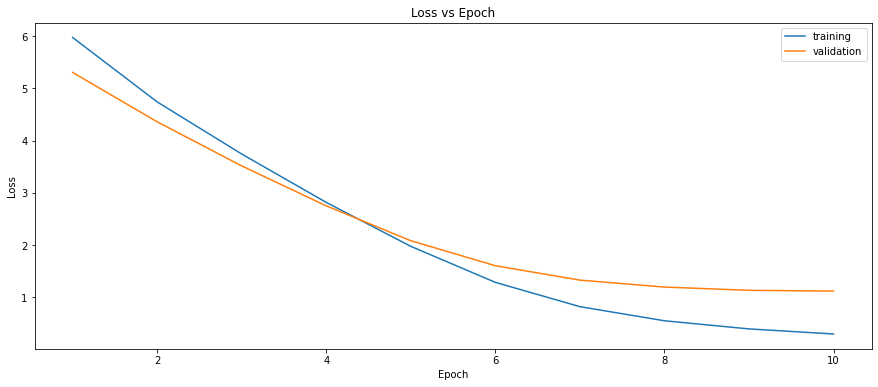

In [ ]:
# Plotting the training and validation losses
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15, 6))
epochs = 1+np.arange(10)
plt.plot(epochs, train_epoch_loss, label='training')
plt.plot(epochs, val_epoch_loss, label='validation')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

## Using the model to translate

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
def translate(english_sentence):

  # Creating Embedding Layer
  list_of_words = english_sentence.split(' ')
  embedded_sentence = embedding_layer(tf.constant(list_of_words))
  embedded_sentence = tf.pad(embedded_sentence, [[13-tf.shape(embedded_sentence)[0], 0], [0, 0]])
  embedded_sentence = tf.expand_dims(embedded_sentence, axis=0)

  # Getting the predicted tokens
  hidden_state, cell_state = encoder_model(embedded_sentence)
  input_token = 1
  count = 0
  predicted_tokens = []
  while (input_token != 2) and (count < 15):
    predicted_tokens.append(input_token)
    input_token_batch = np.expand_dims([input_token], axis=0)
    probs, hidden_state, cell_state = decoder_model(input_token_batch, hidden_state, cell_state)
    input_token = np.argmax(probs[0][0].numpy())
    count += 1
  
  # Returning the translated sentence
  german_sentence = tokenizer.sequences_to_texts([predicted_tokens[1:]])
  return german_sentence[0]

In [ ]:
# Translating 5 random English sentences
inx = np.random.choice(len(english_sentences), 5)
sentence_list = []
for i in inx:
  english_sentence = english_sentences[i]
  german_prediction = translate(english_sentence)
  german_sentence = german_sentences[i][8:-6]
  sentence_list.append([english_sentence, german_prediction, german_sentence])
df = pd.DataFrame(sentence_list, columns=['English Sentence', 'German Prediction', 'German Sentence'])
df

,English Sentence,German Prediction,German Sentence
0,tom sneezed .,tom gaehnte .,tom nieste .
1,am i boring you ?,langweile ich dich ?,langweile ich euch ?
2,it's brand new .,das ist waschtag .,es ist brandneu .
3,tom is a weirdo .,tom ist ein schraeger typ .,tom ist ein komischer kauz .
4,tom is neurotic .,tom ist gehorsam .,tom ist neurotisch .
